### Background and Context:

Twitter posses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other side, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/services on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand, and their competitors, and discover new trends in the industry.

 

### Data Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

### Prepared by:
Plinio Monteiro

In [2]:
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
import seaborn as sns

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PMONTEIR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PMONTEIR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PMONTEIR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import pandas as pd       
df_tweets = pd.read_csv("Tweets.csv")

In [4]:
df_tweets.shape

(14640, 15)

In [5]:
df_tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
print(df_tweets['text'][1])

@VirginAmerica plus you've added commercials to the experience... tacky.


### Observation: 
- Data set is comprised of 14,640 rows (tweets) and 15 columns.
- airline_sentiment and text columns are the columns of interest for this model.
- However, let's perform some EDA

## Exploratory Data Analysis

### Tweets distribution across all Arlines

<AxesSubplot:ylabel='airline'>

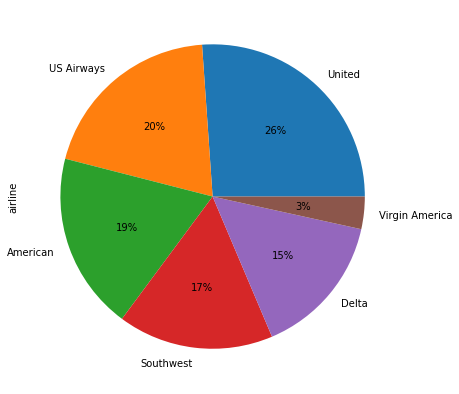

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
df_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

#### Observation: 
- In the pie chart above, we can see the percentage of public tweets for each airline. United Airline has the highest number of tweets i.e. 26%, followed by US Airways (20%).

### Let's see the distribution of sentiments across all tweets

<AxesSubplot:ylabel='airline_sentiment'>

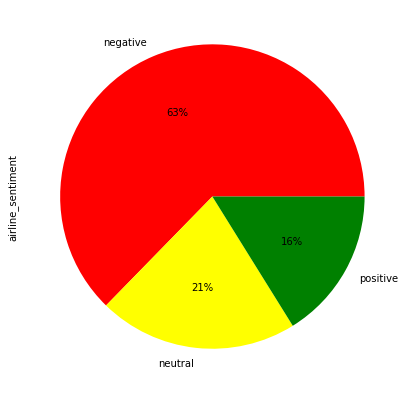

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
df_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

#### Observations:
- From the output above, we can see that the majority of the tweets are negative (63%), followed by neutral tweets (21%), and then the positive tweets (16%).

### Let's see the distribution of sentiment per Airline

<AxesSubplot:xlabel='airline'>

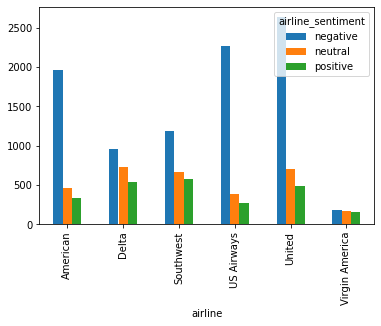

In [9]:
fig.set_size_inches(11, 8)
airline_sentiment = df_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

#### Observation: 
- For almost all the airlines, the majority of the tweets are negative, followed by neutral and positive tweets. Virgin America is probably the only airline where the ratio of the three sentiments is somewhat similar.

<AxesSubplot:xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

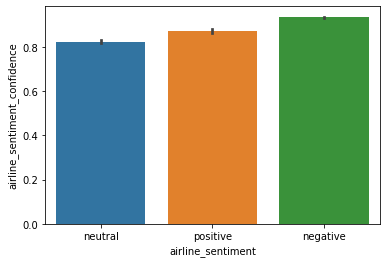

In [10]:
import seaborn as sns
fig.set_size_inches(10, 7)
sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=df_tweets)

#### Observation:
- We can see that the confidence level for negative tweets is higher compared to positive and neutral tweets.

### Let's identify the reasons for the Negative Sentiment per Airline

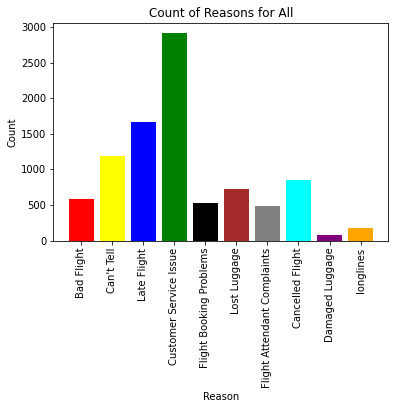

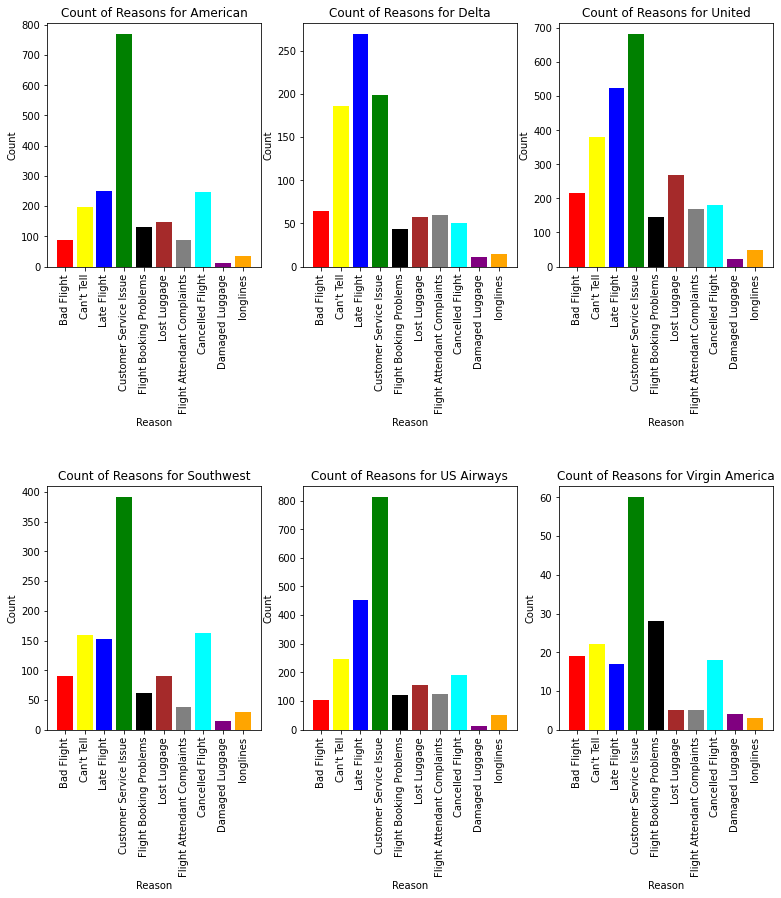

In [11]:
# get the number of negative reasons
df_tweets['negativereason'].nunique()

NR_Count=dict(df_tweets['negativereason'].value_counts(sort=False))

def NR_Count(Airline):
    if Airline=='All':
        a=df_tweets
    else:
        a=df_tweets[df_tweets['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df_tweets['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
airlines = ['American','Delta','United','Southwest','US Airways','Virgin America']
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

#### Observation:
- Delta main reason for negative sentiment is Late Flight while all other Airlines Customer Service Issues are the main reason.

### Word cloud for Negative Tweets

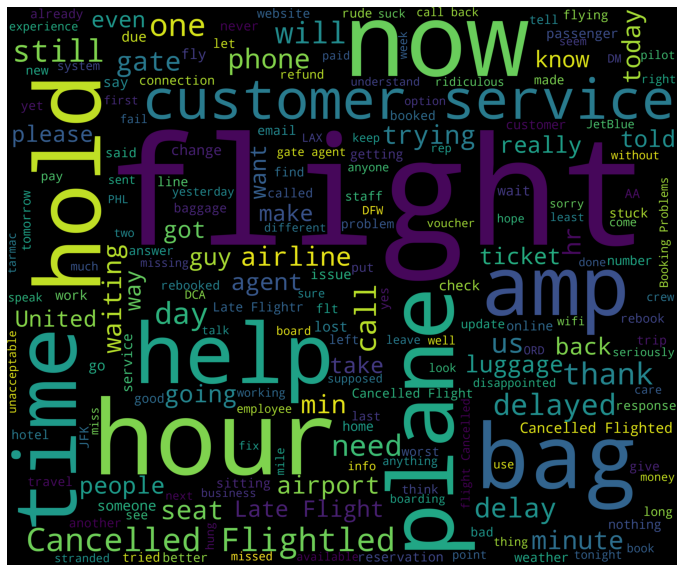

In [12]:
from wordcloud import WordCloud, STOPWORDS
new_df=df_tweets[df_tweets['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- High frequency words such as flight, plane, bag, hour, cancelled, waiting, issue, delay, etc, depict a negative sentiment.

### Word Cloud for Postive Tweets

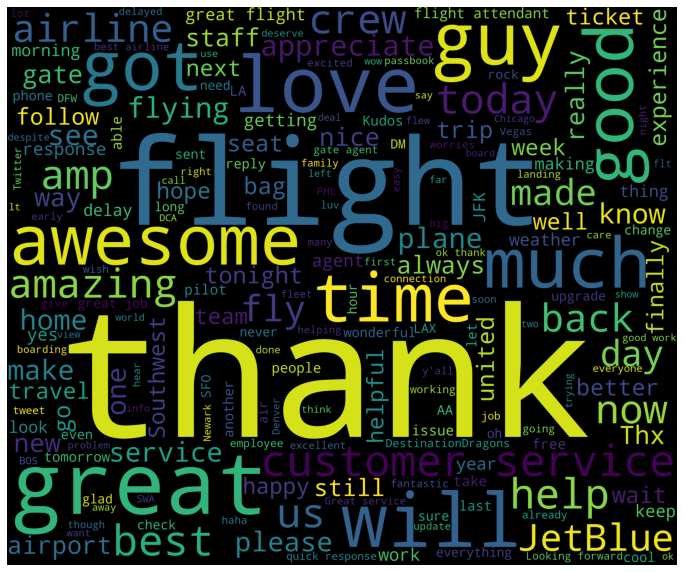

In [13]:
new_df=df_tweets[df_tweets['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Words such as thank, awesome, good, best, love, etc depict a posive sentiment.

### Let's drop unecessary columns for our model

In [14]:
df_tweets.drop(['tweet_id','airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold',
              'name','negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone'],
               inplace=True, axis=1)

In [15]:
df_tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [16]:
df_tweets.shape

(14640, 2)

#### Check for Null values

In [17]:
#
# Check for Null values
#
df_tweets.isnull().sum(axis=0)    

airline_sentiment    0
text                 0
dtype: int64

In [18]:
###################################################################
# Print 10 first rows
###################################################################
pd.set_option('display.max_colwidth', None)      # Display full dataframe information (Non-turncated Text column.)

df_tweets.head(10)                                 # Check first 5 rows of data

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


In [19]:
df_tweets.shape   

(14640, 2)

### Text Pre-Processing 

#### Function pre-process and clean the raw tweets text
- HTML Removal
- Removal of non-letters (Removal of Special Characters and Punctuations)
- Convert the entire text to lower case
- Remove Stop words
- Lemmatize

### Beatiful Soup to remove html tags

In [20]:
from bs4 import BeautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [21]:
df_tweets['text'] = df_tweets['text'].apply(lambda x: strip_html(x))
df_tweets.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


### Remove Contractions

In [22]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df_tweets['text'] = df_tweets['text'].apply(lambda x: replace_contractions(x))
df_tweets.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,positive,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. you are too good to me."


#### Observations:
- Note that "didn't" was replaced with "did not". "it's" was replaced with "it is", etc.

### Remove Numbers from the tweets text

In [23]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

df_tweets['text'] = df_tweets['text'].apply(lambda x: remove_numbers(x))
df_tweets.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $ a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpGgrEZP"
8,positive,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. you are too good to me."


#### Observation:
- Note that the number 30 is no longer present in the sixth tweet.

### Tokenize the tweet text

In [24]:
df_tweets['text'] = df_tweets.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

In [25]:
df_tweets.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


### Functions below to perform the following:
- Remove non-ascii characters
- Convert all characters to lower case
- Remove punctuations
- Remove StopWords
- Lemmatize the text (e.g. running = run, etc.)

In [26]:
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words



In [27]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df_tweets['text'] = df_tweets.apply(lambda row: normalize(row['text']), axis=1)
df_tweets.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


#### Observation:
- The data has been pre-processed and it is now ready to be modeled.

### Model Building

### Vectorization

In [28]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

#########################################################################################################################
# 2000 features to be used as not much gain is achieved above it. Plus, high number of features increase processing time.
#########################################################################################################################

vectorizer = CountVectorizer(max_features=2000)                
data_features = vectorizer.fit_transform(df_tweets['text'])

data_features = data_features.toarray()                        # Convert the data features to array.

In [29]:
data_features.shape

(14640, 2000)

In [30]:
labels = df_tweets['airline_sentiment']

### Let's split the data into training and testing (70/30)

In [31]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

### Let's use Randon Forest to build model for the classification of tweets Sentiment

In [32]:
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7055327868852459


### Predict and Score the model

In [33]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)
model_score = (accuracy_score(y_test, result))

### Let's plot a confusion matrix 

[[2460  261   93]
 [ 379  417   88]
 [ 184  115  395]]


<AxesSubplot:>

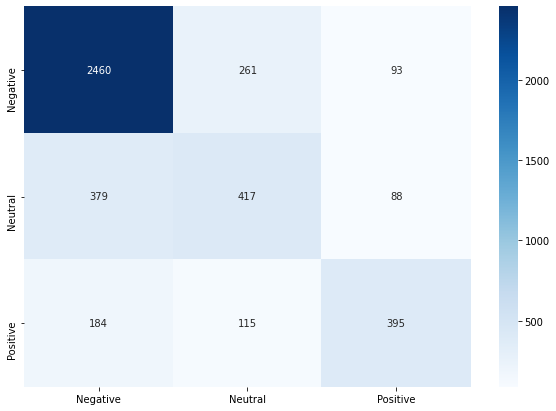

In [34]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

Sentiment = ['Negative', 'Neutral', 'Positive']

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in Sentiment],
                     columns = [i for i in Sentiment])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')

### Get Precision, Recall and F1-Score

In [35]:
print(classification_report(y_test, result))

              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      2814
     neutral       0.53      0.47      0.50       884
    positive       0.69      0.57      0.62       694

    accuracy                           0.74      4392
   macro avg       0.68      0.64      0.65      4392
weighted avg       0.74      0.74      0.74      4392



In [36]:
print('Model Predicted Correctly: {0:.3f} % of the time'.format(model_score * 100))

Model Predicted Correctly: 74.499 % of the time


### Using TF-IDF Vectorizer

In [37]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
data_features = vectorizer.fit_transform(df_tweets['text'])

data_features = data_features.toarray()

data_features.shape

(14640, 2000)

### Let's split the data into training/testing (70/30)

In [38]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

### Let's build the model using Random Forest for the Tweets Sentiments

In [39]:
# Let's also calculate the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.6955601092896174


### Predict and Score the model

In [40]:
result = forest.predict(X_test)
model_score = (accuracy_score(y_test, result))

### Let's build a confusion matrix

<AxesSubplot:>

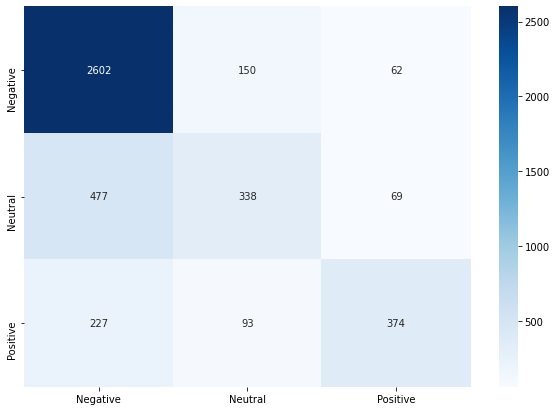

In [41]:
conf_mat = confusion_matrix(y_test, result)

Sentiment = ['Negative', 'Neutral', 'Positive']

df_cm = pd.DataFrame(conf_mat, index = [i for i in Sentiment],
                  columns = [i for i in Sentiment])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')

### Get Precision, Recall and F1-Score

In [42]:
print(classification_report(y_test, result))

              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      2814
     neutral       0.58      0.38      0.46       884
    positive       0.74      0.54      0.62       694

    accuracy                           0.75      4392
   macro avg       0.70      0.62      0.65      4392
weighted avg       0.74      0.75      0.74      4392



In [43]:
print('Model Predicted Correctly: {0:.3f} % of the time'.format(model_score * 100))

Model Predicted Correctly: 75.455 % of the time


## Summary

Airlines Tweets were used for this analysis. There were a total of 14,640 tweets with 15 columns each. An Exploratory Data Analysis was performed and the following was found:<br><br>
United with 26% of the tweets, followed by US Airways, American, Southwest, Delta and Virgin America with 20%, 19%, 17%, 15% and 3% respectively. <br><br>
63% of the tweets were classified as Negative, 21% Neutral and 16% Positive. Tweets are clearly skewed towards the Negative classification. <br><br>
Customer Services was by far the number one reason for Negative sentiment with about 30% of the Negative tweets, followed by late flight. <br><br>
This analysis continued by performing data pre-processing. Data pre-processing involves cleaning up the text. The pre-processing entailed the removal of HTML tags, non-letters characters (special characters and punctuation) and Stop Words. It also involved converting the text into lower case in order to reduce the numbers of words (tokens). Lemmatization was then applied in order to bring the words back to its original root (e.g. running is converted to run, etc). The dataset was split into training and testing (70/30) and a Random Forest model for each one of the Vectorization was applied. <br><br>
After the conclusion of pre-processing, the tweets text are ready for model building and sentiment classification. Two types of vectorization were applied (1-Count Vectorizer and 2-TF-IDF Vectorizer). Count Vectorizer is a way to convert a given set of strings into a frequency representation. While TF-IDF (term frequency times inverse document frequency) is a schema to weight individual tokens. One of the advantage of TF-IDF is to reduce the impact of tokens that occur very frequently, hence offering little to none in terms of information. TF-IDF tends to be better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can also remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.<br><br>
The TF-IDF/Random Forest modeling came up with a better accuracy of .754. While the Count Vectorizer/Random Forest came up with .744. The Recall weighted was a bit better for the TF-IDF while the f1-scores weighted average were the same for both. However, the TF-IDF had better Recall and F1-Score for the Negative classification. In fact, the recall was .92. Given these reasons and the fact that 63% of the dataset is comprised of tweets classified as Negative, I would be inclined to select the TF-IDF over the Count Vectorizer for the Airlines tweets sentiment analysis model to be deployed into Production.  
